# Préparation du dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
df=pd.read_csv('data_propre.csv')

In [3]:
df.columns

Index(['Unnamed: 0', 'uniq_id', 'crawl_timestamp', 'product_url',
       'product_name', 'product_category_tree', 'pid', 'retail_price',
       'discounted_price', 'image', 'is_FK_Advantage_product', 'description',
       'product_rating', 'overall_rating', 'brand', 'product_specifications',
       'sentence_bow', 'sentence_bow_lem', 'sentence_dl'],
      dtype='object')

In [4]:
df_images= df[['product_category_tree', 'image']]

In [5]:
path_images = "C:/Users//User/Desktop/P6/Flipkart/Images"


In [6]:
list_photos = [file for file in listdir(path_images)]

In [7]:
df_images["image_path"] =  path_images + "/" +df_images["image"]

C:\Users\User\AppData\Local\Temp\ipykernel_15340\2211409475.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_images["image_path"] =  path_images + "/" +df_images["image"]


In [8]:
df_images.rename(columns={'product_category_tree':'label_name'},inplace=True)


C:\Users\User\AppData\Local\Temp\ipykernel_15340\2387425039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_images.rename(columns={'product_category_tree':'label_name'},inplace=True)


In [9]:
df_images.head(3)

,label_name,image,image_path
0,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,C:/Users//User/Desktop/P6/Flipkart/Images/55b8...
1,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,C:/Users//User/Desktop/P6/Flipkart/Images/7b72...
2,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,C:/Users//User/Desktop/P6/Flipkart/Images/64d5...


In [10]:
X = df_images.drop('label_name',axis=1)
y=df_images['label_name']

In [11]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, stratify=y, random_state=42)

In [12]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y_train)
y_label = le.transform(y_train)
y_label_test = le.transform(y_test)


# Etape 2 : classification supervisée
2 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images


## Création du modèle de classification

In [13]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

## Approche préparation initiale des images

In [14]:
liste_index_train= X_train.index
liste_index_test=X_test.index

In [15]:
def image_prep_fct(data,liste) :
    prepared_images = []
    for image_num in liste :
        img = (load_img(
            data['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np = image_prep_fct(X_train,liste_index_train)
print(images_np.shape)
images_np_test = image_prep_fct(X_test,liste_index_test)
print(images_np_test.shape)

C:\Users\User\anaconda3\envs\nouveauenvironnement\lib\site-packages\PIL\Image.py:3157: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(703, 224, 224, 3)
(347, 224, 224, 3)


In [16]:
X = images_np
y_train = to_categorical(y_label)

X_test = images_np_test
y_test = to_categorical(y_label_test)

y_train


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [17]:
y.shape

(1050,)

In [18]:
X_train2, X_val, y_train2, y_val = train_test_split(X, y_train, stratify=y_train, test_size=0.25, random_state=42)
X_train2.shape

(527, 224, 224, 3)

In [19]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train2, y_train2, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)


Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 5.4611 - accuracy: 0.4478 
Epoch 1: val_loss improved from inf to 1.30888, saving model to .\model1_best_weights.h5
9/9 [==============================] - 147s 17s/step - loss: 5.4611 - accuracy: 0.4478 - val_loss: 1.3089 - val_accuracy: 0.7386
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 2.3613 - accuracy: 0.6414 
Epoch 2: val_loss improved from 1.30888 to 1.08175, saving model to .\model1_best_weights.h5
9/9 [==============================] - 155s 18s/step - loss: 2.3613 - accuracy: 0.6414 - val_loss: 1.0817 - val_accuracy: 0.7557
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 1.4554 - accuracy: 0.7249 
Epoch 3: val_loss improved from 1.08175 to 1.07698, saving model to .\model1_best_weights.h5
9/9 [==============================] - 166s 19s/step - loss: 1.4554 - accuracy: 0.7249 - val_loss: 1.0770 - val_accuracy: 0.7784
Epoch 4/50
9/9 [==============================] - ETA: 0s -

In [21]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train2, y_train2, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))



17/17 [==============================] - 117s 7s/step - loss: 0.0564 - accuracy: 0.9867
Training Accuracy: 0.9867

6/6 [==============================] - 40s 6s/step - loss: 0.8621 - accuracy: 0.8182
Validation Accuracy:  0.8182


In [22]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8182
Test Accuracy       :  0.7723


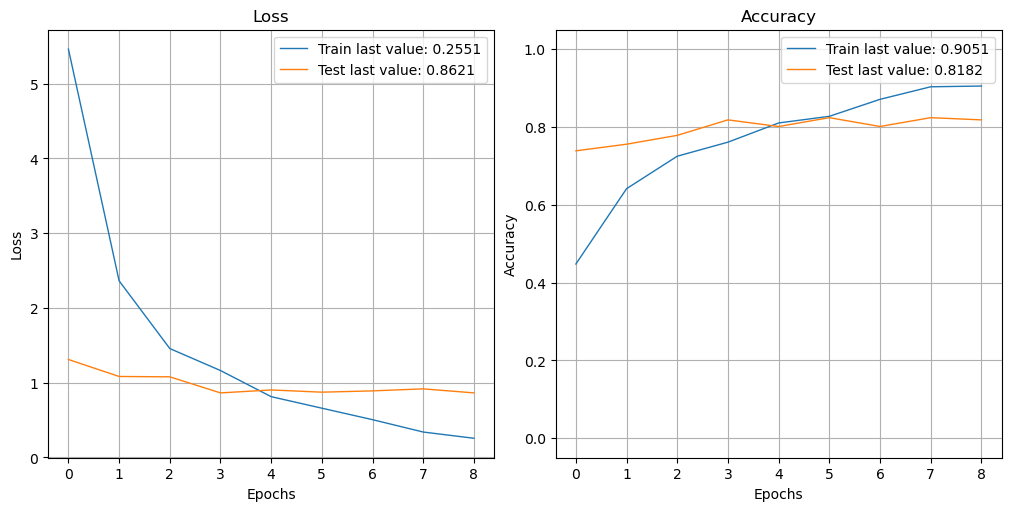

In [23]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [24]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

6/6 [==============================] - 41s 7s/step
[6 0 6 1 2 3 0 0 5 3 6 2 6 5 1 5 0 2 5 4 3 5 3 3 6 1 0 1 0 3 4 1 6 0 0 4 4
 0 2 4 1 4 6 1 4 5 1 2 0 1 3 0 2 5 5 1 1 3 1 6 2 2 2 1 0 0 0 0 1 4 0 4 2 3
 5 6 4 0 6 2 6 5 0 5 3 3 1 3 6 5 5 5 5 1 6 4 4 1 2 3 1 4 5 6 6 4 2 6 4 5 6
 6 2 2 2 0 0 2 4 0 5 1 3 6 2 3 2 2 3 4 5 6 6 2 1 6 5 1 6 3 5 5 2 2 3 1 4 6
 0 1 1 5 2 0 3 3 3 5 0 3 3 4 0 4 4 4 4 4 6 3 1 5 4 3 2 0]

[6 4 6 1 2 3 0 0 5 3 6 2 5 5 1 5 0 2 5 4 3 3 3 3 6 1 4 1 0 3 4 1 6 0 0 4 4
 0 2 4 1 4 6 1 1 5 1 2 3 0 3 0 2 5 5 1 1 3 1 6 2 2 5 1 0 0 5 0 4 4 0 4 2 3
 5 6 4 0 6 2 6 5 5 5 3 6 1 3 6 5 3 5 0 1 6 0 1 1 2 3 2 0 5 6 6 0 2 6 0 5 6
 2 2 2 2 0 0 2 4 0 5 4 0 6 2 3 2 2 3 4 0 6 6 2 1 6 5 1 6 3 5 5 5 2 3 2 4 6
 0 1 1 5 2 0 3 3 3 5 0 3 3 4 4 0 4 0 4 0 6 3 5 5 4 3 1 0]


In [25]:
from sklearn.metrics import classification_report,confusion_matrix


In [26]:

conf_mat = confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[20  0  0  1  3  2  0]
 [ 1 19  2  0  2  1  0]
 [ 0  1 22  0  0  2  0]
 [ 1  0  0 23  0  0  1]
 [ 7  2  0  0 16  0  0]
 [ 2  0  0  2  0 21  0]
 [ 0  0  1  0  0  1 23]]


In [27]:

print(classification_report(y_val_num, y_val_pred))

              precision    recall  f1-score   support

           0       0.65      0.77      0.70        26
           1       0.86      0.76      0.81        25
           2       0.88      0.88      0.88        25
           3       0.88      0.92      0.90        25
           4       0.76      0.64      0.70        25
           5       0.78      0.84      0.81        25
           6       0.96      0.92      0.94        25

    accuracy                           0.82       176
   macro avg       0.82      0.82      0.82       176
weighted avg       0.82      0.82      0.82       176



In [29]:
list_labels = ["Baby Care", "Beauty and Personal Care", "Computers", "Home Decor & Festive Needs","Home Furnishing","Kitchen & Dining","Watches"]


<Axes: >

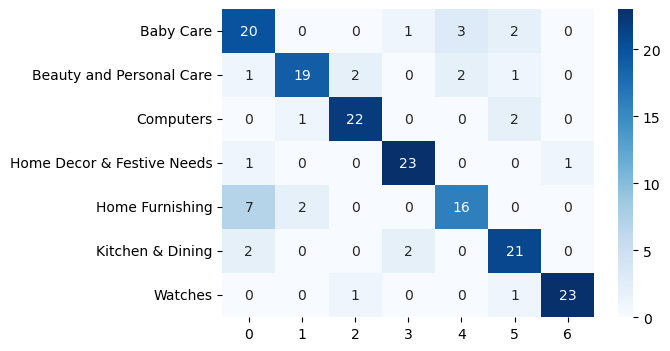

In [30]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [32]:
# Pour mélanger les images, classées initalement par classe
df_images = df_images.sample(frac=1, random_state=42).reset_index(drop=True)

In [33]:
X = df_images.drop('label_name',axis=1)
y=df_images['label_name']

In [34]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, stratify=y, random_state=42)

In [35]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)


In [36]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='label_name',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [37]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(df_train, datagen_train, data_type='training')
val_flow = data_flow_fct(df_train, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(df_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 528 validated image filenames belonging to 7 classes.
Found 175 validated image filenames belonging to 7 classes.
Found 347 validated image filenames belonging to 7 classes.


In [38]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [39]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [40]:
with tf.device('/gpu:0'): 
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
 5/17 [=======>......................] - ETA: 2:10 - loss: 5.5305 - accuracy: 0.3187

C:\Users\User\anaconda3\envs\nouveauenvironnement\lib\site-packages\PIL\Image.py:3157: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


17/17 [==============================] - ETA: 0s - loss: 3.9763 - accuracy: 0.4545
Epoch 1: val_loss improved from inf to 1.34958, saving model to .\model2_best_weights.h5
17/17 [==============================] - 226s 13s/step - loss: 3.9763 - accuracy: 0.4545 - val_loss: 1.3496 - val_accuracy: 0.6457
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 1.6542 - accuracy: 0.6345
Epoch 2: val_loss improved from 1.34958 to 1.07382, saving model to .\model2_best_weights.h5
17/17 [==============================] - 215s 13s/step - loss: 1.6542 - accuracy: 0.6345 - val_loss: 1.0738 - val_accuracy: 0.7314
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 1.2371 - accuracy: 0.7292
Epoch 3: val_loss did not improve from 1.07382
17/17 [==============================] - 227s 13s/step - loss: 1.2371 - accuracy: 0.7292 - val_loss: 1.1246 - val_accuracy: 0.7371
Epoch 4/50
17/17 [==============================] - ETA: 0s - loss: 0.7835 - accuracy: 0.7746 
Epoch 4: val

In [41]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

17/17 [==============================] - 173s 10s/step - loss: 0.0580 - accuracy: 0.9830
Training Accuracy   : 0.9830

6/6 [==============================] - 57s 9s/step - loss: 1.0156 - accuracy: 0.7486
Validation Accuracy :  0.7486


In [42]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7257
Test Accuracy       :  0.8040


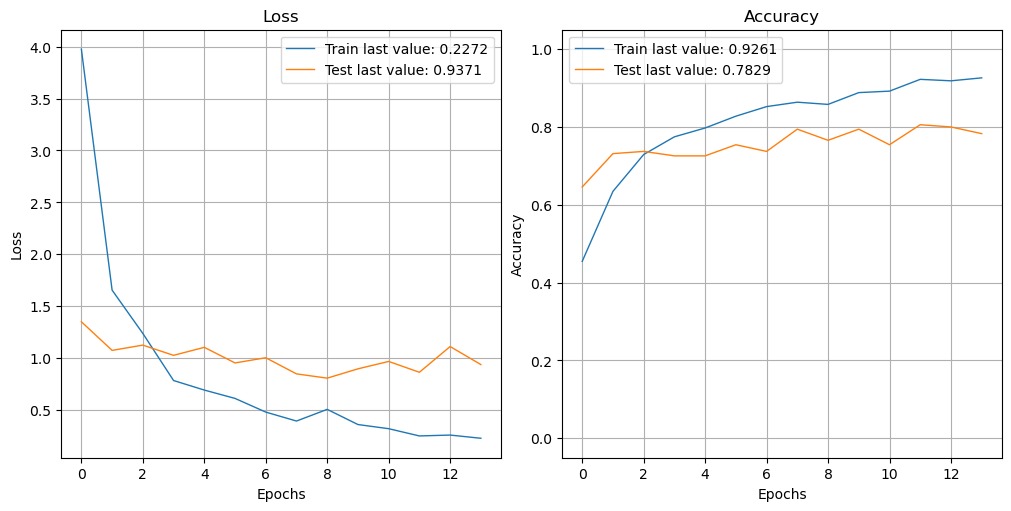

In [43]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()